# TD Learning Basics

In the previous notebook, we've seem that we can account for simple forms of learning using variants of **Rescorla-Wagner learning**.

However, this learning model is very **limited** to simple cases of **delay conditioning**, where the CS is still present when the US arrives.

**Temporal Difference (TD) learning** is a very powerful framework that incorporates insights from both learning theory and optimal control. 

As we see below, TD-learning allows to **backpropagate** value estimates through time, and thus account for **trace conditioning** problems (where the CS is off before the US appears). In the same way, TD-learning can account for higher-order conditioning, where a predictive relationship between a second CS and the first CS is established, such that the reward is already predicted by the new CS.

This notebook guides through the basic principles of TD-learning. The structure of the code is inspired by the excellent TD learning tutorial from Neuromatch 2020 (https://academy.neuromatch.io/nma2020/course-materials).

We start with the usual imports and defining some helper functions.

In [22]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [23]:
# @title Helper functions to plot

def plot_value_function(V, CS=None, US=None):
  # Plot value estimates

  plt.stem(V, use_line_collection=True) # stem plot (vertical lines at x location from baseline to y, and place marker there)
  plt.ylabel('Value')
  plt.xlabel('State')
  plt.title("Value function: $V(s)$")

  if (not CS and not US):
    x_tick_vals = np.linspace(0,len(V),5).astype(int)
    x_tick_lab = x_tick_vals
  else:
    x_tick_vals = [0,CS,US,len(V)]
    x_tick_lab  = [0,"CS","US",len(V)]

  plt.xticks(x_tick_vals,x_tick_lab)
  plt.show()

def plot_tde_trace(TDE, skip=400):
  # Plot TD Error

  indx = np.arange(0, TDE.shape[1], skip)
  im = plt.imshow(TDE[:,indx])

  plt.xticks([0,10,20,30,40],np.linspace(0,np.size(TDE,1),5).astype(int))
  plt.yticks([0,10,20,30])

  plt.title('TD-error over learning')
  plt.ylabel('State')
  plt.xlabel('Iterations')
  plt.colorbar(im)
  
  plt.show()

TD learning modifies the way value is learned in a small but decisive way:

$$V_t \leftarrow V_t + \alpha \cdot (r+\gamma \cdot V_{t+1}-V_t) \tag{1} $$ 

There are now two key changes:


*   We now deal with **real time $t$**, depending on some arbitrary temporal resolution of a problem
*   We include the term $\gamma \cdot V_{t+1}$ in the prediciton error term. Think of this as an **additional reward**. This gives an agent the sense of not only the **immediate reward but also the reward that is likely to follow** in the future.

The change to include $\gamma \cdot V_{t+1}$ seems small, but it has substantial consequences in how reward information can be learnt and **back-propagated** in time.

$\gamma$ is a **discount parameter**, and roughly translates into how much you value future reward in relation to immediate reward. Consequently, $\gamma$ is reasonably bounded between [0,1] and is also an important parameter to account for delay discounting tendencies in individual behaviour.

In general, the TD learning framework is highly flexible and often serves as a (reasonable) benchmark even in complex learning problems.



---
# Part 1: TD Algorithm

Let's define a simple application: a trial has 40 time-steps, and an animal receives an unconditioned stimulus (US) (i.e. a primary reward, such as juice drops) at time-step 20. However, we deliver a conditioned stimulus (CS) after 10 trials (i.e., at time-step 10 since we start counting at 0). 

How does value learning under a TD model look like in such a task?

In [24]:
def td_learner(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward = 1
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

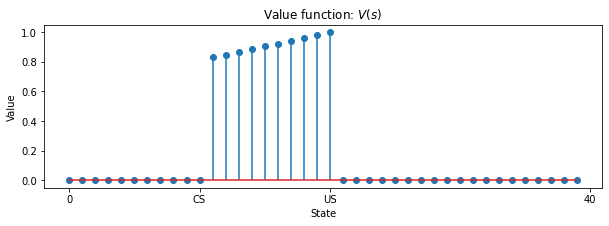

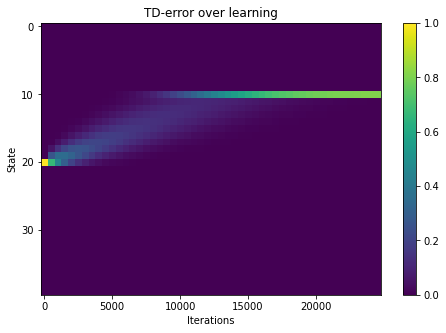

In [25]:
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)
# print(V)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)
# print(TDE[:,-1])

Note that the way we defined the algorithm implies that the CS does not have a value itself, but evokes a positive prediction error because it *predicts* the begin of the delay period to the reward.

In [26]:
# @title Exercise 1.1: How does TD work?

These are complicated plots. Do you understand what's going on?

Why does the value of states between the CS and US gradually increase? Why is it 0 in all other states?

Can you explain the gradual change of the TD-error over the simulations?

In [27]:
# @title Exercise 1.2: How does the TD error work?

Can you work out **numerically** (use the TD error in equation 1 above):

i) the TD error at the very first delivery of the US (row 20, first column in the second (image) plot above?)

ii) the TD error at the very last delivery of the US (row 20, last column in the second (image) plot above?)

iii) the TD error at the very first delivery of the CS (row 10, first column in the second (image) plot above?)

iv) the TD error at the very last delivery of the CS (row 10, last column in the second (image) plot above?)

---
# Part 2: Parameters of the TD Algorithm

In [28]:
# @title Exercise 2.1: Importance of delayed rewards

What happens if the value of next time step is not included? Define a function called 'rw_learner' (or so) that does the same thing as the td_learner function above, but in a Rescorla-Wagner way. What do you observe when plotting the results?

In [29]:
# Your code goes here

In [30]:
# @title Partial Solution

def rw_learner(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward = 1
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      #####
      # uncomment and implement the Rescorla Wagner prediction error:
      # TDE[state, n] = ...
      #####


      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = rw_learner(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

In [31]:
# @title Full Solution

def rw_learner(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward = 1
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward  - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

print("Output should look like this:")

V, TDE = rw_learner(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

In [ ]:
# @title Exercise 2.2: Importance of $\gamma$

What's the role of $\gamma$? What do the results look like with a smaller $\gamma$, or when you set $\gamma$ to 0 or 1?

In [ ]:
# Your code goes here

In [32]:
# @title Full Solution

print("Output should look like this:")

# i) low gamma:
print("Low gamma:")
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=0.60, alpha=0.001)
plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

# i) Gamma=1:
print("Gamma=1:")
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=1, alpha=0.001)
plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

# i) Gamma=0:
print("Gamma=0:")
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=0, alpha=0.001)
plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

In [ ]:
# @title Exercise 2.3: importance of $\alpha$

How do the results change under different learning rates $\alpha$?

In [ ]:
# Your code goes here

In [33]:
# @title Full Solution

print("Output should look like this:")

# i) Low alpha:
print("Low alpha:")
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.0001)
plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

# i) High alpha:
print("High alpha:")
V, TDE = td_learner(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.1)
plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

---
# Part 3: Different reward values

In [ ]:
# @title Exercise 3.1: Multiple reward values

Implement a function that applies TD-learning, but now the reward is not always consistent. Let's start with situations in which there are different reward values - but the agent ALWAYS obtains some positive reward (note that this is different from the reward sampling in the previous notebook).

Specifically, try a case like reward_vals = [0.6,1.4] sampled with 50% each - i.e. a case where there are several reward values, but the expected value is the same as in the consistent reward case.

In [ ]:
# Your code goes here

In [34]:
# @title Partial Solution

def td_learner_multR(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        #####
        reward = 0 # comment this line
        # uncomment and implement sampling from multiple reward values:
        # reward = ... 
        #####
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = td_learner_multR(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

In [35]:
# @title Full Solution

def td_learner_multR(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward=np.random.choice([0.6,1.4])
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = td_learner_multR(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

print("Output should look like this:")

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

If implemented correctly, you should now see that there are also negative TD errors. Why?

---
# Part 4: Probabilistic reward

In [ ]:
# @title Exercise 4.1: Stochastic reward delivery

Now, implement a function that delivers probabilistic reward, i.e. some positive reward with a certain probability or no reward (reward = 0) with some other probability.

In [ ]:
# Your code goes here

In [36]:
# @title Partial Solution

def td_learner_probR(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        #####
        reward = 0 # comment this line
        # uncomment and implement sampling from multiple reward values:
        # reward = ... 
        #####
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = td_learner_probR(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

In [37]:
# @title Full Solution

def td_learner_probR(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward=np.random.choice([0,1])
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 0

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = td_learner_probR(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

print("Output should look like this:")

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

How is this different or similar to the multiple reward value case?

In [ ]:
# @title Exercise 4.2: Learning rate in stochastic reward delivery

What happens if you use a very high learning rate (e.g. $\alpha$ = 1) when there is probabilistic reward?

In [ ]:
# Your code goes here

In [38]:
# @title Full Solution
V, TDE = td_learner_probR(n_trials=20000, n_steps=40, gamma=0.98, alpha=1)

print("Output should look like this:")

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)

---
# Bonus: How to define the CS-US period

These simulations rely on a 'hack' that restricts value learning and back-propagation to the period between CS-US. What happens when you relax that restrition?

You can check this by defining a new function of a td learner where the variable is_delay is always 1.

The output looks quite different. Can you see what's going on? How might this relate to real animal behaviour in the lab?

In [ ]:
# Your code goes here

In [39]:
# @title Full Solution

def td_learner_Norestrict(n_trials=1000, n_steps=40, gamma=0.98, alpha=0.2):
  """ Temporal Difference learning

  Input:
    n_trials (int): the number of trials to run
    n_steps (int): length of a trial (= temporal resolution)
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """

  V = np.zeros(n_steps) # Array to store values over states (time)
  TDE = np.zeros((n_steps, n_trials)) # Array to store TD errors

  for n in np.arange(n_trials):

    state = 0 # Initial state

    for t in np.arange(n_steps):

      # Get next state and next reward
      if state < n_steps - 1: 
        next_state = state + 1 # increase state if trial not finished
      else:
        next_state = 0 # reset state to initial state otherwise (this can account for an interesting effect, see below)

      if state == 20:
        reward = 1
      else:
        reward = 0

      # Is the current state in the delay period (after CS)?
      if (state<=20 and state>10):
        is_delay = 1
      else:
        is_delay = 1

      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state
  
  return V, TDE

V, TDE = td_learner_Norestrict(n_trials=20000, n_steps=40, gamma=0.98, alpha=0.001)

print("Output should look like this:")

plt.rcParams['figure.figsize'] = [10, 3]
plot_value_function(V,10,20)

plt.rcParams['figure.figsize'] = [8, 5]
plot_tde_trace(TDE)